# План -- залог успеха

1. Предобрабатываем и анализируем тексты
    * Строим облако слов в т.ч.
2. Пробуем разные подходы к токенизации
3. Исключаем и не исключаем стоп-слова
4. Да и нет лемматизации//стеммингу
5. Простые векторизации: bag-of-words, CountVectorizer, TfIdfVectorizer
    * Уни-, би- и другие граммы
6. Модели: логрег, SVM
7. Катбуст с текстовыми фичами
8. Аналитика результатов
9. Предложения ребят(ам), как можно улучшить прогноз
    * языковые фичи;
    * аугментации текстов;
    * ...

На любые вопросы по этой домашке постарается ответить Савелий (TG: @Savely_Prokhorov). Не стесняйтесь спрашивать, ему будет приятно помочь.

И помните:

> Не существует глупых вопросов!

Вы можете что-то не знать из того, что нужно для полного выполнения этой домашки -- и это не стыдно. Давайте учиться вместе!

В этом ноутбуке мы выделили **жирным** некоторые рекомендации по тому, что можно улучшить в бейзлайне, чтобы попытаться выбить скор получше.  

Модели давайте сравнивать по $R^2$ ([Вики про коэффициент детерминации](https://en.wikipedia.org/wiki/Coefficient_of_determination))



> **Сохраняйте промежуточные результаты: некоторые алгоритмы отрабатывают довольно долго, обидно будет потерять результаты вычислений; к тому же сохранённые модели (вместе с пайплайнами предобработки, если они отличаются) будет легче состекать**



> А ещё вам могут быть полезны [пайплайны из sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). Если хорошо приспособите -- будет довольно удобно




In [1]:
pip install pymorphy2

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Lasso

import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer

from gensim.models import Word2Vec

from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12, 8]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aleksandrlazarev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aleksandrlazarev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aleksandrlazarev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/aleksandrlazarev/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Загрузка данных

In [3]:
df_train = pd.read_csv('vacancies_train.csv')
df_train

name          experience  \
0                                    Водитель-экспедитор       От 3 до 6 лет   
1                    Кладовщик-комплектовщик/оператор 1С  От 1 года до 3 лет   
2      Продавец магазина "Магнит" (Кировский р-он, В....           Нет опыта   
3                       Администратор магазина (ТЦ Spar)  От 1 года до 3 лет   
4                              Мойщик посуды (кулинария)           Нет опыта   
...                                                  ...                 ...   
16624             Полицейский специального полка полиции           Нет опыта   
16625           Врач стоматолог-ортопед (г. Новосибирск)           Нет опыта   
16626                                          Фармацевт  От 1 года до 3 лет   
16627                             Геодезист (автодороги)  От 1 года до 3 лет   
16628    Специалист-эксперт отдела правового обеспечения           Нет опыта   

             schedule        employment  \
0         Полный день  Полная занятость   
1         Полный день  Полная занятость   
2      Сменный график  Полная занятость   
3         Полный день  Полная занятость   
4      Сменный график  Полная занятость   
...               ...               ...   
16624     Полный день  Полная занятость   
16625     Полный день  Полная занятость   
16626     Полный день  Полная занятость   
16627  Вахтовый метод  Полная занятость   
16628     Полный день  Полная занятость   

                                             description  \
0      Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ ...   
1      Обязанности:   Списывание материалов в произво...   
2      В крупнейшую Федеральную сеть магазинов "Магни...   
3      Крупная федеральная сеть магазинов мужской и ж...   
4      Обязанности:  Уборка производственных площадей...   
...                                                  ...   
16624  Обязанности:   обеспечение общественного поряд...   
16625  Обязанности:  Оказывает квалифицированную меди...   
16626  Условия:  официальное оформление по ТК РФ; гра...   
16627  Обязанности:  своевременное и качественное вып...   
16628  Обязанности:  правовое сопровождение деятельно...   

                                              key_skills   salary  
0                                                     []  42500.0  
1      ['знание пк', 'работа в 1С', 'Работа в команде...  50000.0  
2                                                     []  31500.0  
3                                                     []  36700.0  
4      ['Пользователь ПК', 'Грамотная речь', 'Работа ...  37000.0  
...                                                  ...      ...  
16624  ['Грамотная речь', 'Обучение и развитие', 'Упр...  67500.0  
16625                       ['Медицинская документация']  50000.0  
16626  ['Пользователь ПК', 'Работа в команде', 'Грамо...  50000.0  
16627                                                 []  75000.0  
16628  ['Грамотная речь', 'Пользователь ПК', 'Умение ...  25000.0  

[16629 rows x 7 columns]

In [4]:
df_test = pd.read_csv('vacancies_test.csv', index_col=0) # честный тест -- для него у вас не будет ответов
# а вот на валидацию можете себе, сколько нужно, откусить от трейна
df_test

name          experience  \
id                                                                            
0                                     Главный бухгалтер         Более 6 лет   
1                           Ассистент врача-стоматолога  От 1 года до 3 лет   
2                                  Менеджер по продажам  От 1 года до 3 лет   
3                                              Менеджер  От 1 года до 3 лет   
4                                 Администратор хостела           Нет опыта   
...                                                 ...                 ...   
5538  Специалист по дистанционному контролю качества...  От 1 года до 3 лет   
5539                               Продавец-консультант           Нет опыта   
5540                 Фельдшер скорой медицинской помощи       От 3 до 6 лет   
5541                               Продавец-консультант           Нет опыта   
5542   Торговый представитель (Колпино, Тосно, Кировск)  От 1 года до 3 лет   

              schedule        employment  \
id                                         
0          Полный день  Полная занятость   
1       Сменный график  Полная занятость   
2          Полный день  Полная занятость   
3          Полный день  Полная занятость   
4       Сменный график  Полная занятость   
...                ...               ...   
5538  Удаленная работа  Полная занятость   
5539       Полный день  Полная занятость   
5540    Сменный график  Полная занятость   
5541       Полный день  Полная занятость   
5542       Полный день  Полная занятость   

                                            description  \
id                                                        
0     Обязанности:Осуществление организации бухгалте...   
1     Обязанности:  Ассистировать врачу стоматологу,...   
2     Если ты:    хочешь построить карьеру в банковс...   
3       Динамично развивающаяся на протяжении 17 лет...   
4     ВОЗМОЖНА РАБОТА С ПРОЖИВАНИЕМ Обязанности:  Пр...   
...                                                 ...   
5538  Обязанности:   проводить визуальный контроль а...   
5539  Компания ONE SMOKE приглашает к сотрудничеству...   
5540  Обязанности:  Осуществляет оказание скорой мед...   
5541  Мечтаешь быть уникальной? Хочешь дарить клиент...   
5542  Компания ТД Мегаполис - крупный дистрибьютор п...   

                                             key_skills  
id                                                       
0     ['1С: Предприятие 8', '1C: Предприятие', 'Рабо...  
1     ['Пользователь ПК', 'Работа в команде', 'Умени...  
2                                                    []  
3     ['Оценка потребностей клиентов', 'оформление д...  
4                                                    []  
...                                                 ...  
5538  ['Удаленная работа', 'Грамотная речь', 'Пользо...  
5539  ['Пользователь ПК', 'Розничная торговля', 'Раб...  
5540                                                 []  
5541  ['Работа в команде', 'Грамотная речь', 'Ориент...  
5542  ['Традиционная розница', 'работа с текущей баз...  

[5543 rows x 6 columns]

# Простейший EDA

Для начала посмотрим на распределение таргета в трейне. Видим выбросы совсем низкой зарплаты. **Посмотрите на описание вакансий с выбросами** -- это может помочь объяснить их.

<Axes: xlabel='salary', ylabel='Count'>

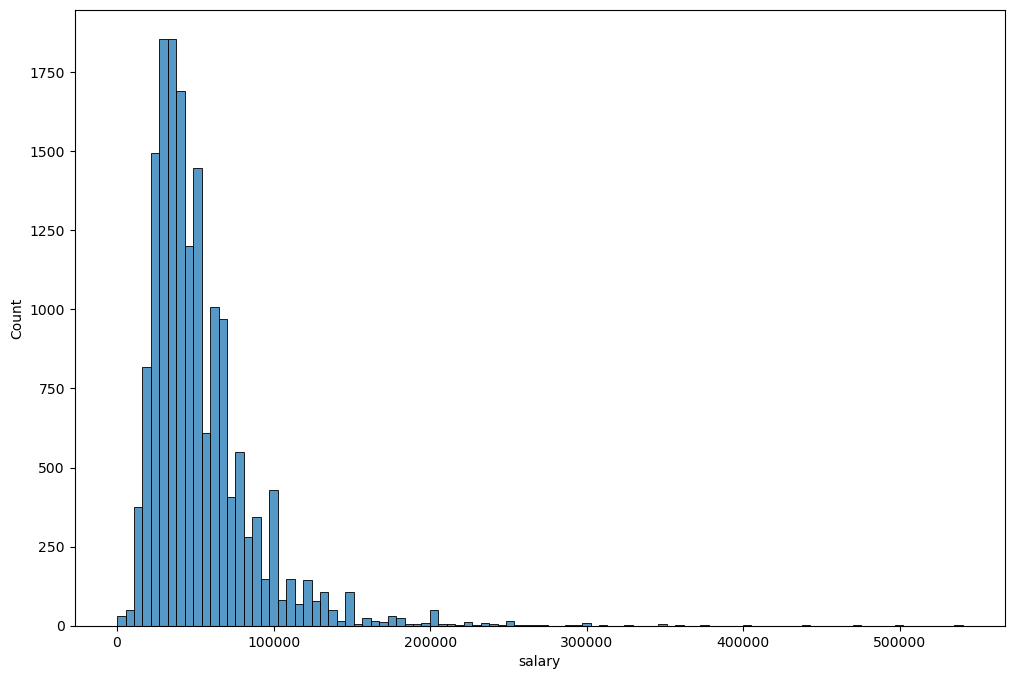

In [5]:
sns.histplot(df_train.salary, bins=100)

In [6]:
too_low = df_train.sort_values("salary")
with open('vibrosizp.txt', 'w') as f:
    for i in too_low.description:
        f.write(i+'\n\n')
too_low[:60]


name          experience  \
2641            Продавец консультант/старший(ТЦ Эльгрин)  От 1 года до 3 лет   
16235                          Комплектовщик (Тарасовка)           Нет опыта   
13491                                  Инженер-экономист  От 1 года до 3 лет   
163    Ведущий специалист/Руководитель тендерного отдела       От 3 до 6 лет   
9696                                         Фрезеровщик  От 1 года до 3 лет   
13252                     Уборщица/уборщик игрового зала           Нет опыта   
1904                             Официант на мероприятия           Нет опыта   
13173                                         Автомойщик           Нет опыта   
6453                                          Интервьюер           Нет опыта   
2682               Работник торгового зала, г. Череповец           Нет опыта   
3988                       Работник торгового зала (Лоо)           Нет опыта   
13075                                           Официант  От 1 года до 3 лет   
11311                   Подработка с ежедневной выплатой           Нет опыта   
621                                      Повар-универсал           Нет опыта   
8708                                    Шеф-повар, повар           Нет опыта   
3990                                            Охранник           Нет опыта   
282         Сотрудник на пересчет товара/счетчик-ревизор           Нет опыта   
275                         Сотрудник на пересчет товара           Нет опыта   
9171                                 Мерчендайзер (Ашан)  От 1 года до 3 лет   
3460                                          Монолитчик       От 3 до 6 лет   
5245                     Мерчендайзер (напитки), Лебяжье  От 1 года до 3 лет   
2639                        Мерчендайзер, Зима (напитки)  От 1 года до 3 лет   
5268     Курьер пеший/авто к партнеру сервиса Яндекс.Еда           Нет опыта   
5840                                 Водитель-экспедитор       От 3 до 6 лет   
6147                            Домработница/Домработник  От 1 года до 3 лет   
10827                             Интерн отдела развития           Нет опыта   
7739                         Мерчендайзер (Красное село)           Нет опыта   
15160                                  Уборщик помещений           Нет опыта   
10056                                      Администратор           Нет опыта   
2953                                Мерчандайзер (Лента)  От 1 года до 3 лет   
16276                             Ассистент руководителя  От 1 года до 3 лет   
4360                              Мерчендайзер (Северск)           Нет опыта   
1890                             Секретарь выходного дня           Нет опыта   
16568                                      Офис-менеджер           Нет опыта   
367                         Помощница / Помощник по дому  От 1 года до 3 лет   
2588      Администратор массажной студии - выходного дня           Нет опыта   
4970           Подсобный рабочий (Красноармейский район)           Нет опыта   
13821                        Уборщик служебных помещений           Нет опыта   
9560                        Уборщик территории (дворник)           Нет опыта   
6304                         Уборщик помещения (Маркина)           Нет опыта   
8705                                Курьер выходного дня           Нет опыта   
9375                                   Санитарка/санитар           Нет опыта   
15042                          Преподаватель информатики  От 1 года до 3 лет   
16506             Визитный мерчендайзер в Ханты-Мансийск           Нет опыта   
1798                                    Уборщица/Уборщик           Нет опыта   
5865                               Мерчендайзер визитный  От 1 года до 3 лет   
6598                                   Уборщик помещений           Нет опыта   
1811                                        Мерчендайзер  От 1 года до 3 лет   
3494                                        Мерчендайзер  От 1 года до 3 лет   
2929                                        Мерченда

В логарифмированной шкале распределение больше похоже на нормальное (ежели отбросить левый хвост с выбросом). **Подумайте, возможно стоит как-нибудь обработать выбросы или их удалить**

<Axes: xlabel='salary', ylabel='Count'>

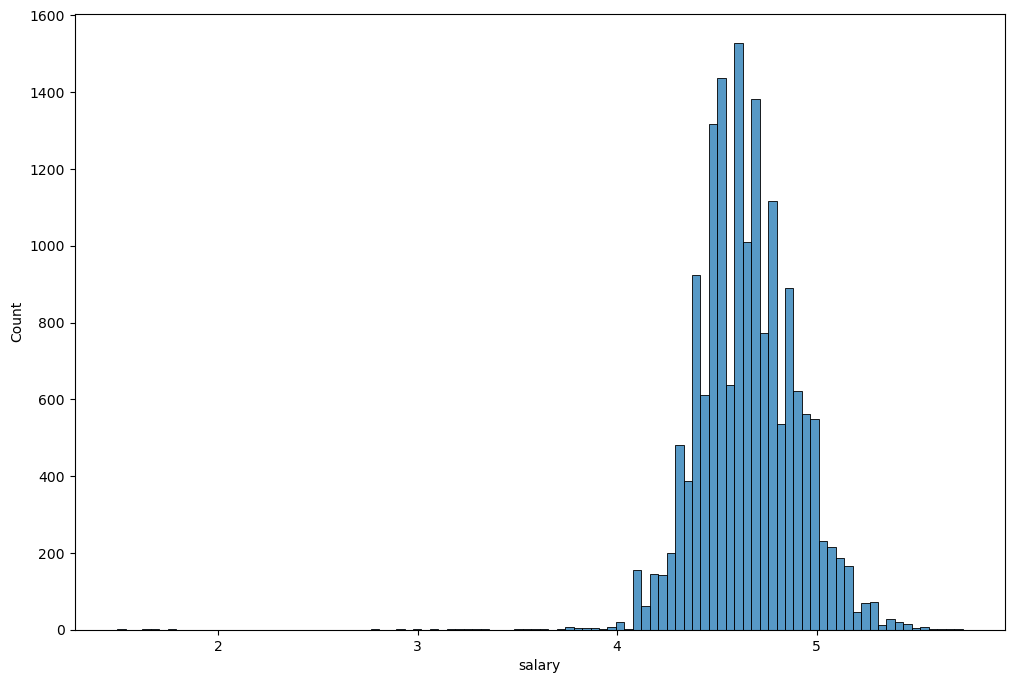

In [7]:
sns.histplot(np.log10(df_train.salary + 1), bins=100)

In [8]:
df_train.name.value_counts()

Менеджер по продажам                                          208
Продавец-консультант                                          180
Менеджер по работе с клиентами                                111
Кладовщик                                                     111
Бухгалтер                                                     108
                                                             ... 
Упаковщица/Упаковщик                                            1
Помощник официанта,ранер                                        1
Менеджер по продаже оборудования для общепита и торговли        1
Электросварщик на полуавтомат (морской регистр, НАКС НГДО)      1
Специалист-эксперт отдела правового обеспечения                 1
Name: name, Length: 9915, dtype: int64

In [9]:
to_remove = []
for i, val in enumerate(np.log10(df_train.salary + 1)):
    if val < 3.5:
        to_remove.append(i)
        print(val)


1.7481880270062005
3.3224260524059526
3.3224260524059526
3.2555137128195333
2.9036325160842376
1.4913616938342726
3.0610753236297916
3.16761267272753
3.3012470886362113
3.000434077479319
3.2555137128195333
3.342620042553348
1.7853298350107671
3.2043913319193
3.1763806922432702
3.000434077479319
2.7788744720027396
1.662757831681574
1.6532125137753437


Выбросы можно объяснить укказанием посменной зп (да, я прочитал много описаний 💀) или нежеланием работодателя адекватно присылать отчет (первые 5). В теории можно было бы свести посменную зп к месячной прикидыванием возможного числа смен но это не очень объективно. Тем более после логарифмирования от относительно нормального распределения нас отделяют какие-то жалкие 20 показателей зп, которые ни туда ни сюда и на общуюю картину по идее они влиять не будут. Или мне все же не хватает бэкграунда чтобы сделать с данными что-то кроме нормализации и откидывание глупых показателей. Короче я считаю, что выбросы низких значений можно выкинуть после логарифмирования.

<Axes: xlabel='salary', ylabel='Count'>

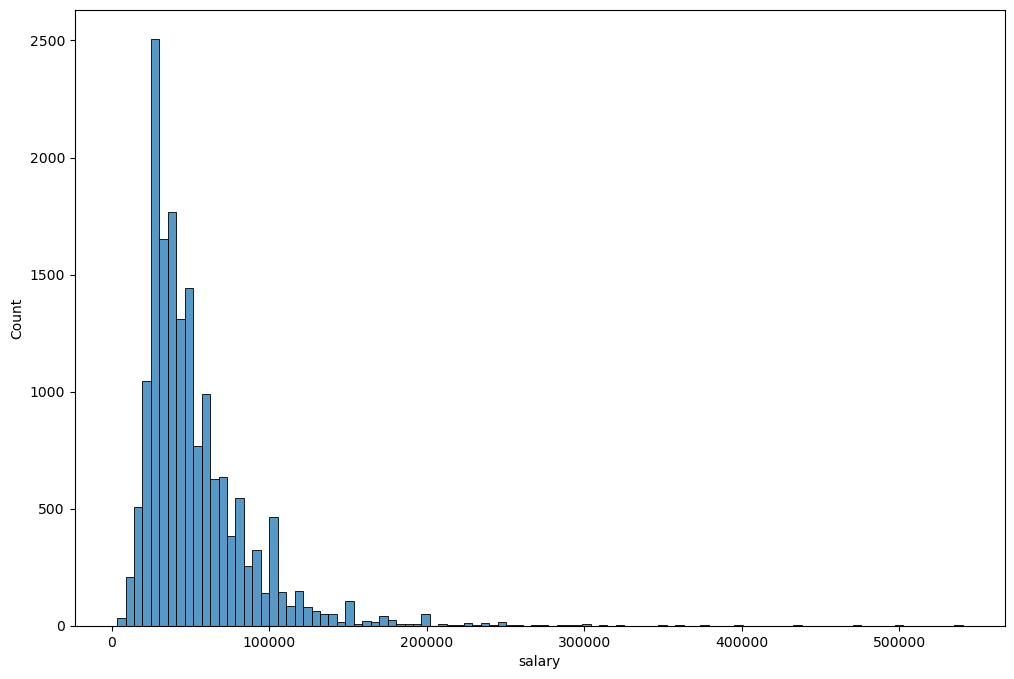

In [10]:
df_train = df_train.loc[np.log10(df_train.salary + 1) >= 3.5]
sns.histplot(df_train.salary, bins=100)

<Axes: xlabel='salary', ylabel='Count'>

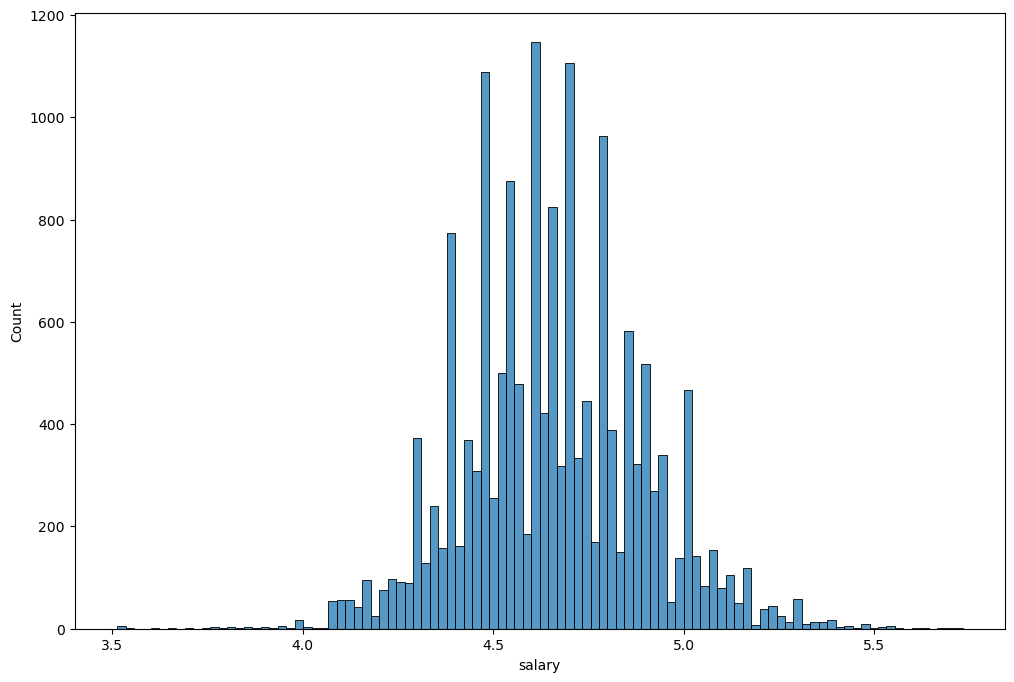

In [11]:
sns.histplot(np.log10(df_train.salary + 1), bins=100)

По графику ниже, видим, что вакансий для опытных соискателей сравнительно немного. **Попробуйте визуализировать совместное распределение опыта работы и предлагаемой зп**

<Axes: xlabel='experience', ylabel='Count'>

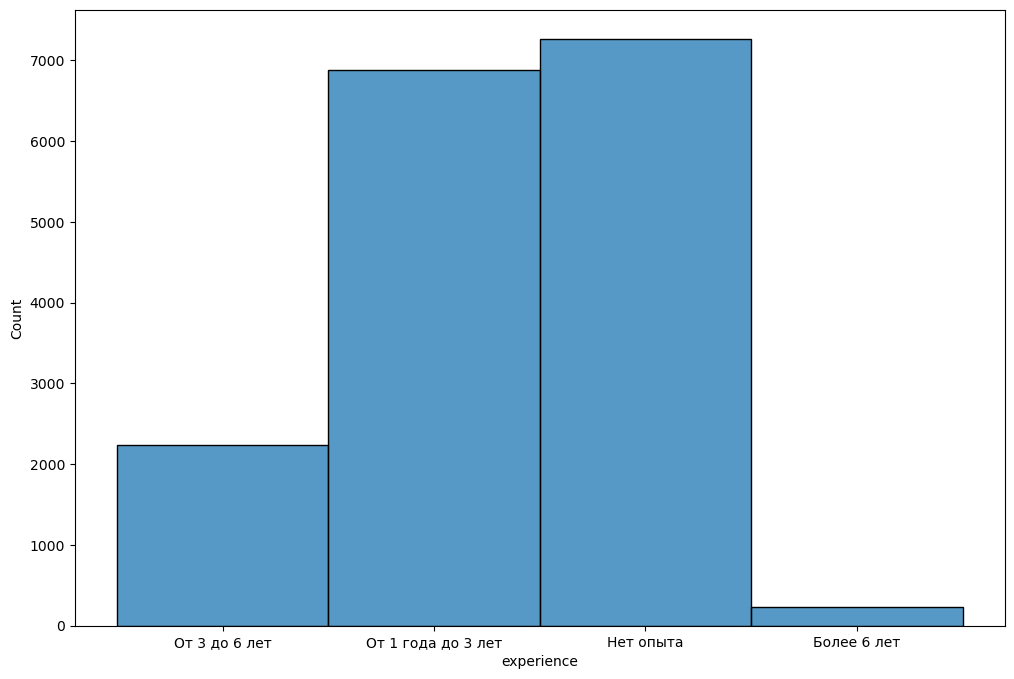

In [12]:
tmp = []
#tmp.append(df_train.salary)
tmp.append(df_train.experience)
sns.histplot(df_train.experience)

<Axes: xlabel='salary', ylabel='Count'>

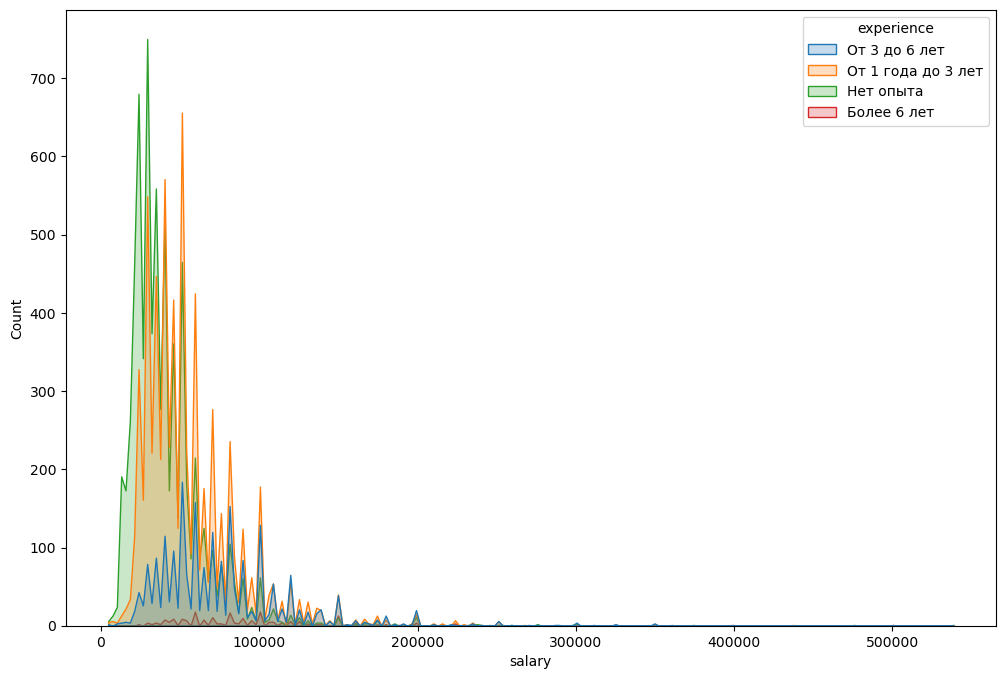

In [13]:
sns.histplot(data=df_train, x="salary", hue='experience', element="poly")


Вакансий с графиком занятости, отличной от полной, совсем не много. **Наверное стоит отдельно посмотреть, не отличается ли описание таких вакансий**.

<Axes: xlabel='schedule', ylabel='Count'>

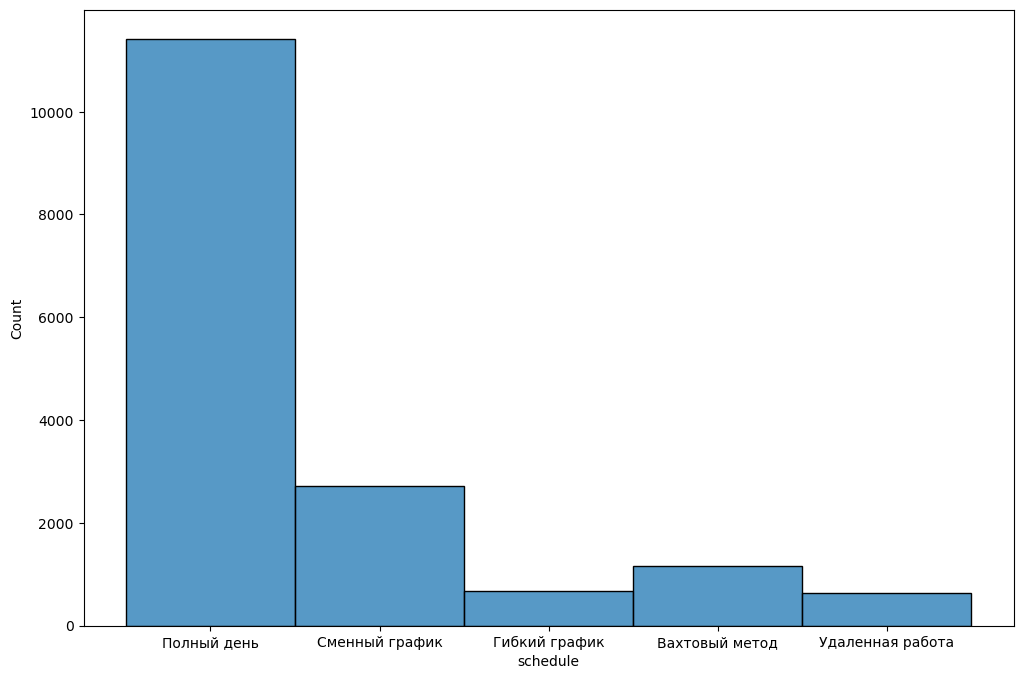

In [14]:
sns.histplot(df_train.schedule)

<Axes: xlabel='employment', ylabel='Count'>

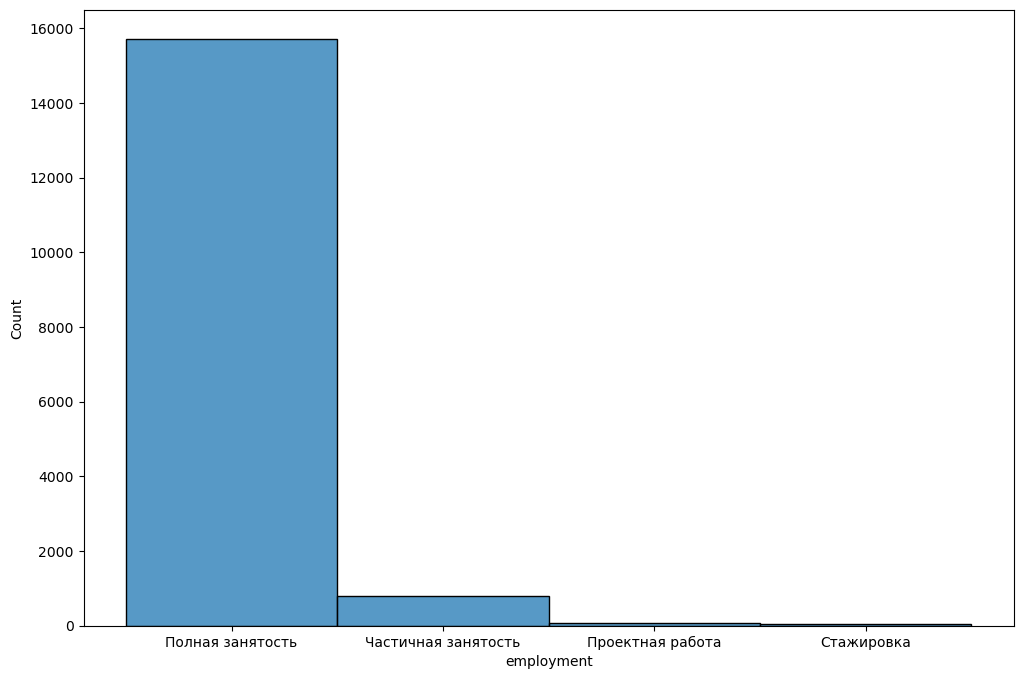

In [15]:
sns.histplot(df_train.employment)

Для решения не придумал ничего лучше, чем считать количество одинаковых лемматизированных токенов...

In [16]:
!pip install pymystem3

In [17]:
from pymystem3 import Mystem
import pymystem3
mystem_analyzer = Mystem()

In [18]:
!pip install wordcloud
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aleksandrlazarev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

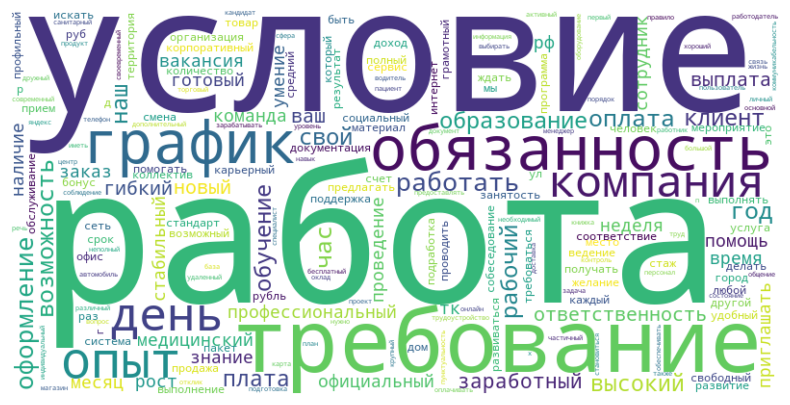

In [19]:
import re
import nltk
from wordcloud import WordCloud
stop_words = set(stopwords.words('russian'))

disc_chast = df_train.loc[df_train.employment == "Частичная занятость"].description
words = {}
for i in disc_chast:
    clean_text = re.sub(r'[^а-яёА-ЯЁ]', ' ', i)
    lower_text = clean_text.lower()
    sing = lower_text.split()
    filtered_words = [word for word in sing if word not in stop_words]
    filtered_text = ' '.join(filtered_words)
    cur = set(mystem_analyzer.lemmatize(filtered_text))
    for j in cur:
        words.setdefault(j, 1)
        words[j] += 1
sorted_words = {k: v for k, v in sorted(words.items(), key=lambda item: item[1], reverse=True) if k!=' ' and k!='\n'}
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(sorted_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

до вырисовывания облака много чего выводил и мнение сложилосб противоречивое. Ну как бэ все описания разные, но составленны в деловом стиле с целью завлечь побольше работников. Миллионы возможностей, гибких графиков и мноооого работы.

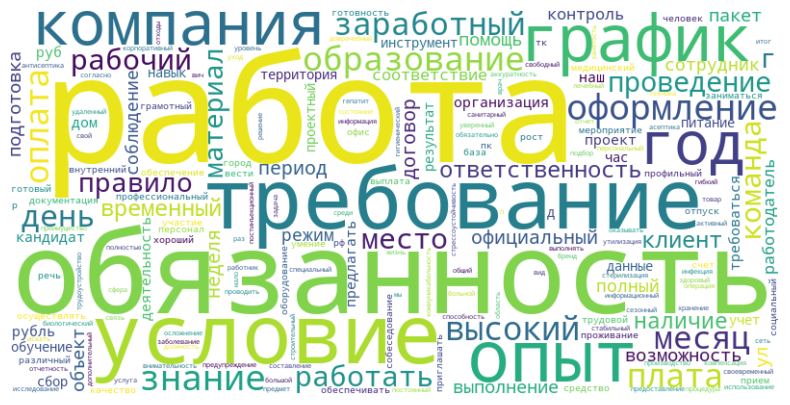

In [20]:
disc_proj = df_train.loc[df_train.employment == "Проектная работа"].description
words = {}
for i in disc_proj:
    clean_text = re.sub(r'[^а-яёА-ЯЁ]', ' ', i)
    lower_text = clean_text.lower()
    sing = lower_text.split()
    filtered_words = [word for word in sing if word not in stop_words]
    filtered_text = ' '.join(filtered_words)
    cur = set(mystem_analyzer.lemmatize(filtered_text))
    for j in cur:
        words.setdefault(j, 1)
        words[j] += 1
sorted_words = {k: v for k, v in sorted(words.items(), key=lambda item: item[1], reverse=True) if k!=' ' and k!='\n'}
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(sorted_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Все для людей, тянущихся к знаниям. Ну и много работы, да. Тут ддобавилось очень мнго слов про образование и коммюнити, что вполне ожидаемо.

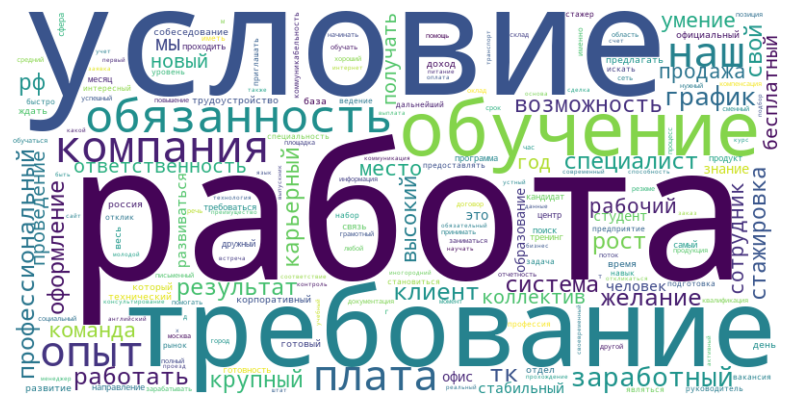

In [21]:
disc_staj = df_train.loc[df_train.employment == "Стажировка"].description
words = {}
for i in disc_staj:
    clean_text = re.sub(r'[^а-яёА-ЯЁ]', ' ', i)
    lower_text = clean_text.lower()
    sing = lower_text.split()
    filtered_words = [word for word in sing if word not in stop_words]
    filtered_text = ' '.join(filtered_words)
    cur = set(mystem_analyzer.lemmatize(filtered_text))
    for j in cur:
        words.setdefault(j, 1)
        words[j] += 1
sorted_words = {k: v for k, v in sorted(words.items(), key=lambda item: item[1], reverse=True) if k!=' ' and k!='\n'}
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(sorted_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Наверное самый легко отличимых класс из-за слова обучение в связке со словами студент, желание и опыт

Посмотрим, как часто различные требуемые навыки встречаются в поле `key_skills`. Логично предположить, что некоторые из них оказывают значимое влияние на предлагаемую зарплату. **Попробуйте проверить эту гипотезу**

In [22]:
from ast import literal_eval
from collections import OrderedDict

In [23]:
skills_count = dict()

for skill_list in df_train.key_skills:
    list_of_skills = literal_eval(skill_list)
    for skill in list_of_skills:
        if skill not in skills_count:
            skills_count[skill] = 1
        else:
            skills_count[skill] += 1

skills_count = {k: v for k, v in sorted(skills_count.items(), key=lambda item: item[1], reverse=True)}
with open('qualities.txt', 'w') as f:
    for i, val in skills_count.items():
        f.write(f'{i}: {val}\n')

In [24]:
for i, skill in enumerate(skills_count.keys()):
    df_train[skill] = df_train['key_skills'].apply(lambda x: int(skill in x))
df_train

/var/folders/pq/9jyd75g16_sf2l8pb2mnfw180000gn/T/ipykernel_6667/4089215609.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[skill] = df_train['key_skills'].apply(lambda x: int(skill in x))
/var/folders/pq/9jyd75g16_sf2l8pb2mnfw180000gn/T/ipykernel_6667/4089215609.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[skill] = df_train['key_skills'].apply(lambda x: int(skill in x))
/var/folders/pq/9jyd75g16_sf2l8pb2mnfw180000gn/T/ipykernel_6667/4089215609.py:2: SettingWithCopyWarning: 
A va

name          experience  \
0                                    Водитель-экспедитор       От 3 до 6 лет   
1                    Кладовщик-комплектовщик/оператор 1С  От 1 года до 3 лет   
2      Продавец магазина "Магнит" (Кировский р-он, В....           Нет опыта   
3                       Администратор магазина (ТЦ Spar)  От 1 года до 3 лет   
4                              Мойщик посуды (кулинария)           Нет опыта   
...                                                  ...                 ...   
16624             Полицейский специального полка полиции           Нет опыта   
16625           Врач стоматолог-ортопед (г. Новосибирск)           Нет опыта   
16626                                          Фармацевт  От 1 года до 3 лет   
16627                             Геодезист (автодороги)  От 1 года до 3 лет   
16628    Специалист-эксперт отдела правового обеспечения           Нет опыта   

             schedule        employment  \
0         Полный день  Полная занятость   
1         Полный день  Полная занятость   
2      Сменный график  Полная занятость   
3         Полный день  Полная занятость   
4      Сменный график  Полная занятость   
...               ...               ...   
16624     Полный день  Полная занятость   
16625     Полный день  Полная занятость   
16626     Полный день  Полная занятость   
16627  Вахтовый метод  Полная занятость   
16628     Полный день  Полная занятость   

                                             description  \
0      Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ ...   
1      Обязанности:   Списывание материалов в произво...   
2      В крупнейшую Федеральную сеть магазинов "Магни...   
3      Крупная федеральная сеть магазинов мужской и ж...   
4      Обязанности:  Уборка производственных площадей...   
...                                                  ...   
16624  Обязанности:   обеспечение общественного поряд...   
16625  Обязанности:  Оказывает квалифицированную меди...   
16626  Условия:  официальное оформление по ТК РФ; гра...   
16627  Обязанности:  своевременное и качественное вып...   
16628  Обязанности:  правовое сопровождение деятельно...   

                                              key_skills   salary  \
0                                                     []  42500.0   
1      ['знание пк', 'работа в 1С', 'Работа в команде...  50000.0   
2                                                     []  31500.0   
3                                                     []  36700.0   
4      ['Пользователь ПК', 'Грамотная речь', 'Работа ...  37000.0   
...                                                  ...      ...   
16624  ['Грамотная речь', 'Обучение и развитие', 'Упр...  67500.0   
16625                       ['Медицинская документация']  50000.0   
16626  ['Пользователь ПК', 'Работа в команде', 'Грамо...  50000.0   
16627                                                 []  75000.0   
16628  ['Грамотная речь', 'Пользователь ПК', 'Умение ...  25000.0   

       Работа в команде  Пользователь ПК  Грамотная речь  ...  работа в CRM  \
0                     0                0               0  ...             0   
1                     1                0               0  ...             0   
2                     0                0               0  ...             0   
3                     0                0               0  ...             0   
4                     0                1               1  ...             0   
...                 ...              ...             ...  ...           ...   
16624                 0                0               1  ...             0   
16625                 0                0               0  ...             0   
16626                 1                1               1  ...             0   
16627                 0                0               0  ...             0   
16628                 0                1               1  ...             0   

       1С:ERP  Высокая работоспособность и стрессоустойчивость  \
0        

In [25]:
correlation_matrix = df_train[['salary'] + list(skills_count.keys())].corr()

In [26]:
absolute_correlation_matrix = correlation_matrix.abs()
top_20_features = absolute_correlation_matrix["salary"].nlargest(21).index
df_selected_features = df_train.loc[:, top_20_features]
top_20_correlation_matrix = df_selected_features.corr()
print(top_20_correlation_matrix)


                        salary       SQL       Git      Java  PostgreSQL  \
salary                1.000000  0.184479  0.145839  0.130418    0.126624   
SQL                   0.184479  1.000000  0.476971  0.474894    0.450595   
Git                   0.145839  0.476971  1.000000  0.421929    0.330062   
Java                  0.130418  0.474894  0.421929  1.000000    0.193599   
PostgreSQL            0.126624  0.450595  0.330062  0.193599    1.000000   
Ведение переговоров   0.111980 -0.018107 -0.013192 -0.014899   -0.008159   
-                     0.109211  0.064270  0.036251  0.032811   -0.001223   
Spring Framework      0.107475  0.226713  0.154894  0.310297    0.251301   
Docker                0.104173  0.203794  0.311698  0.136837    0.251664   
Python                0.104036  0.305158  0.178226  0.175120    0.257905   
Стратегия Развития    0.101270 -0.000708 -0.000516 -0.000582   -0.000319   
Spring                0.101045  0.241999  0.183891  0.327092    0.298141   
Строительств

<Axes: >

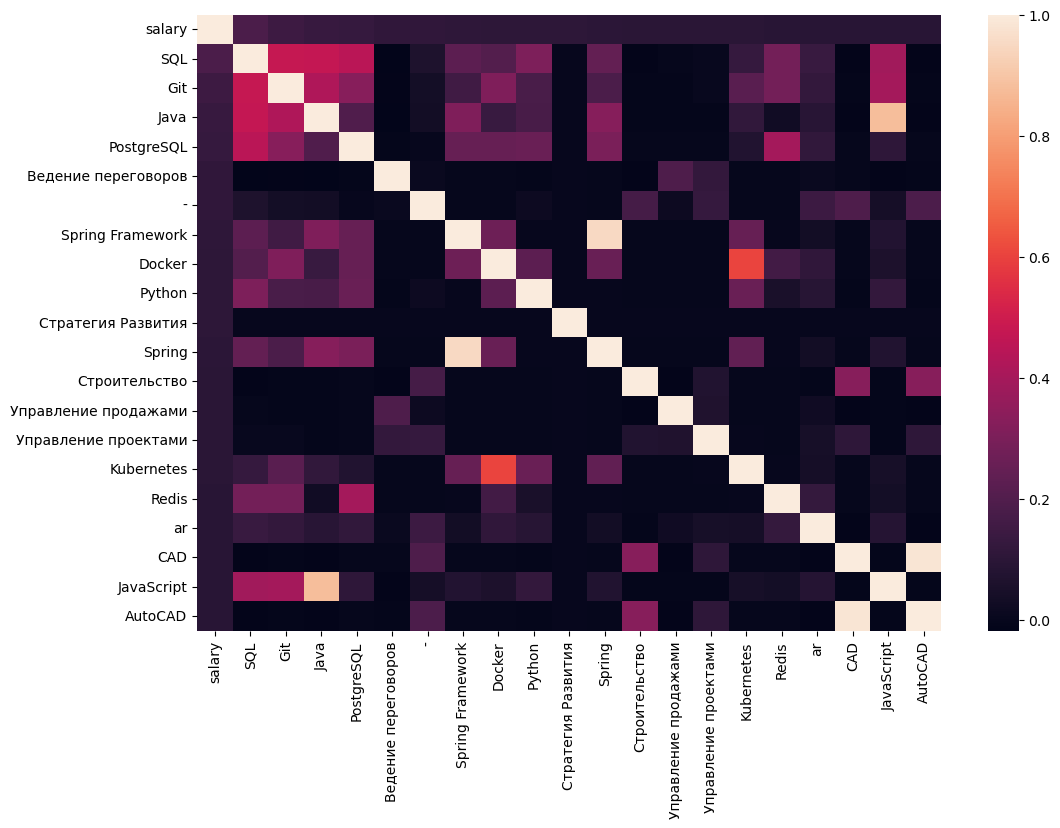

In [27]:
sns.heatmap(top_20_correlation_matrix)

Мне кажется это был один из самых наглядных способов убедиться, что вакансии для одной зарплаты могут описываться совершенно разными требуемыми хорактеристиками. Никакой корреляции нет, следовательно по ним нечего предсказывать

**Визуализацию данных из тестового датасета мы предлагаем вам сделать самостоятельно**. Вполне может оказаться так, что они сильно отличаются от трейна.

<Axes: xlabel='experience', ylabel='Count'>

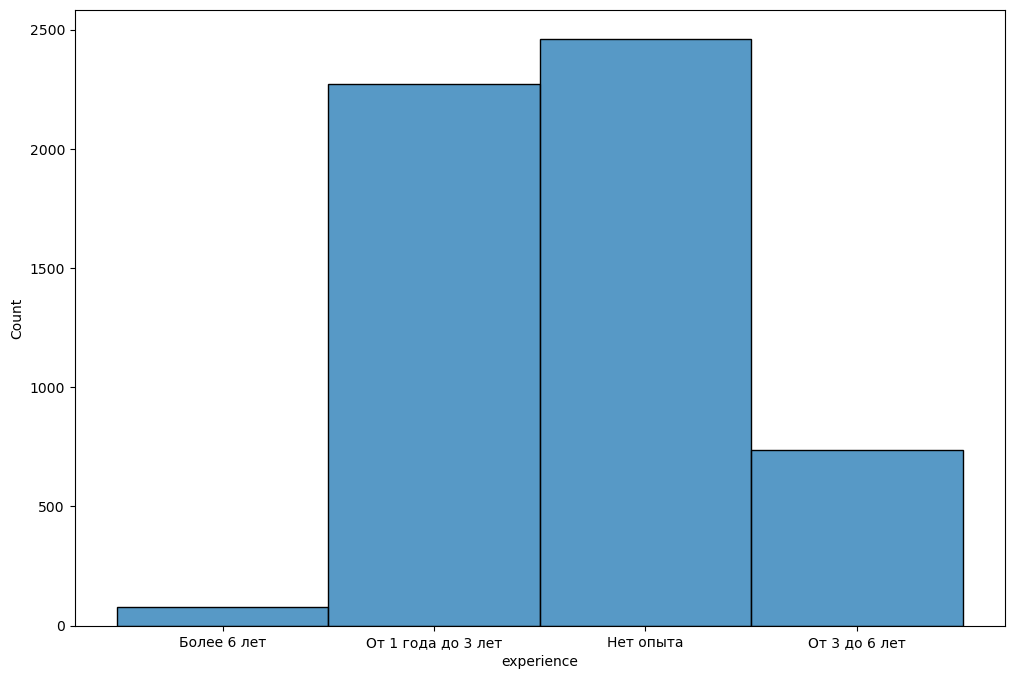

In [28]:
sns.histplot(df_test.experience)


<Axes: xlabel='schedule', ylabel='Count'>

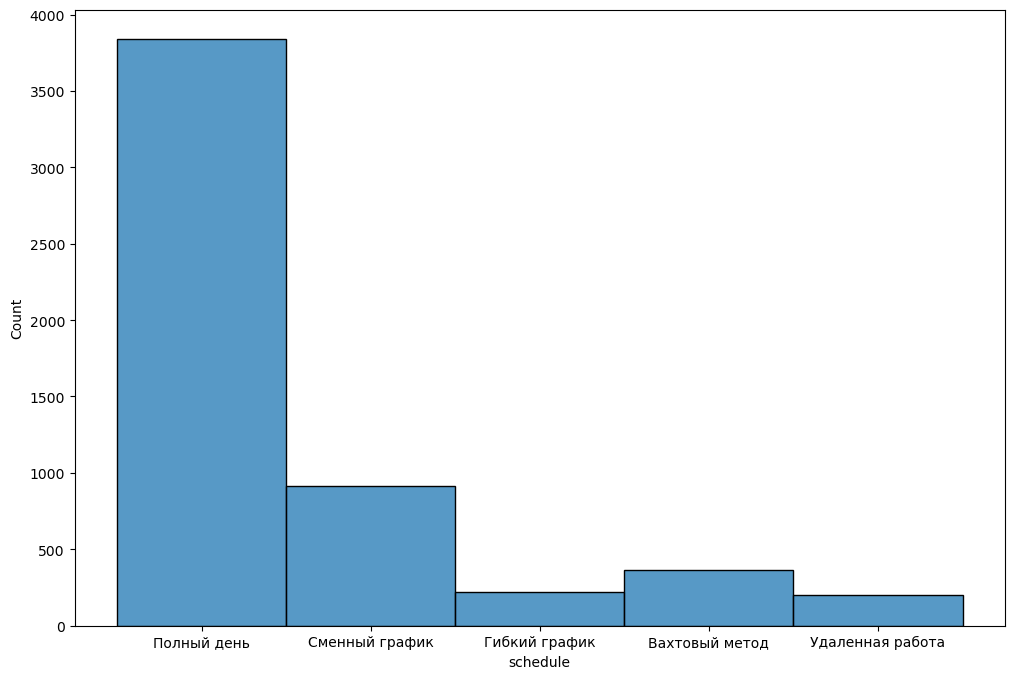

In [29]:
sns.histplot(df_test.schedule)

<Axes: xlabel='employment', ylabel='Count'>

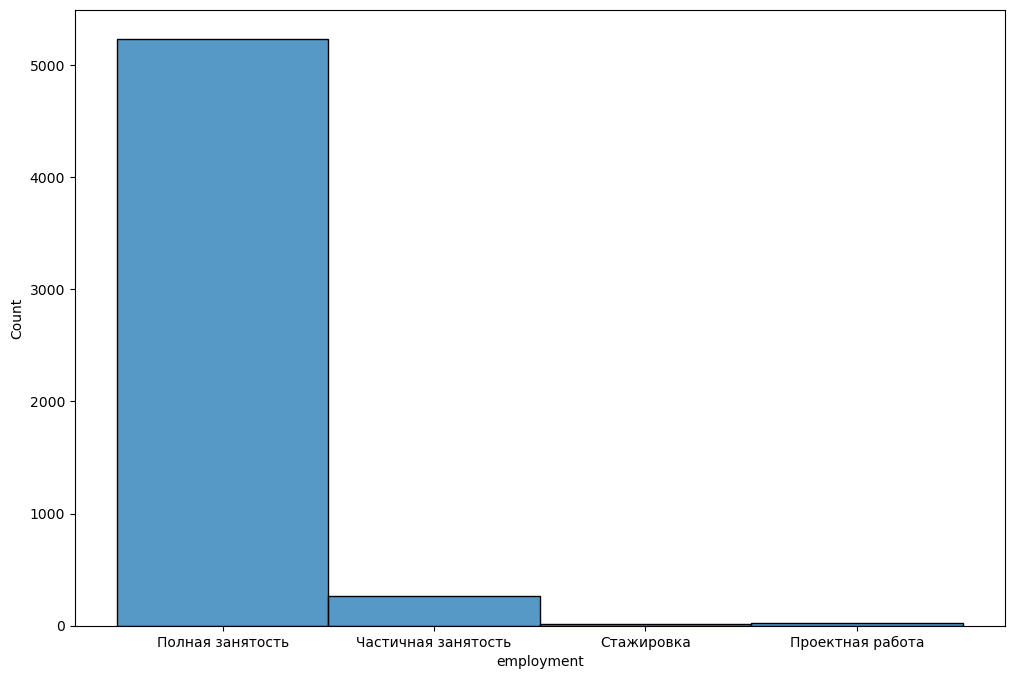

In [30]:
sns.histplot(df_test.employment)

In [31]:
skills_count = dict()

for skill_list in df_test.key_skills:
    list_of_skills = literal_eval(skill_list)
    for skill in list_of_skills:
        if skill not in skills_count:
            skills_count[skill] = 1
        else:
            skills_count[skill] += 1

skills_count = {k: v for k, v in sorted(skills_count.items(), key=lambda item: item[1], reverse=True)}
with open('qualities.txt', 'w') as f:
    for i, val in skills_count.items():
        f.write(f'{i}: {val}\n')

***ОНИ ВО ВСЕМ ИДЕНТИЧНЫ***

Постройте облако слов в описаниях вакансий

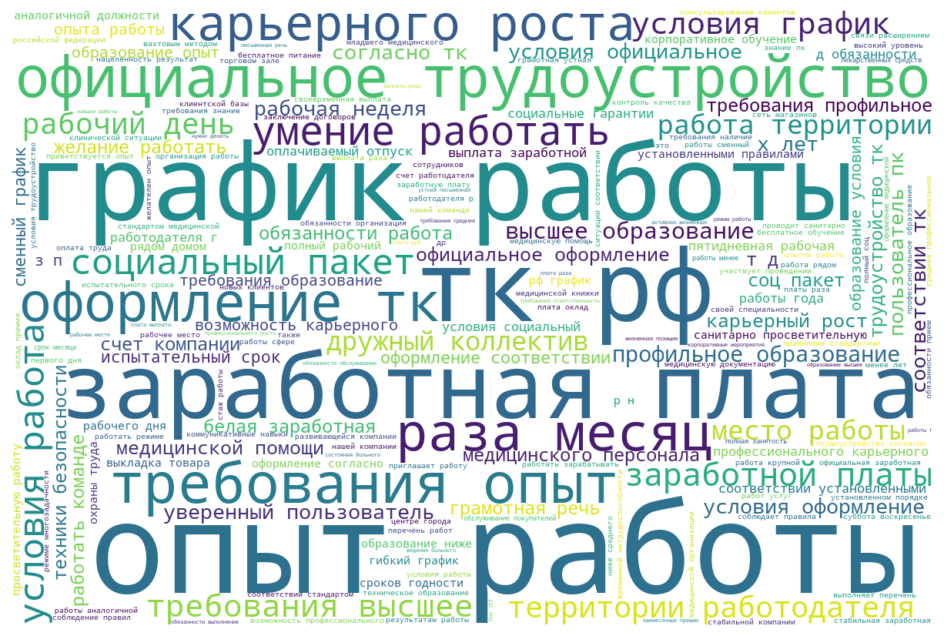

In [32]:
descps = ' '.join(df_train['description'].tolist()) + ' '.join(df_test['description'].tolist())
clean_text = re.sub(r'[^а-яёА-ЯЁ]', ' ', descps)
lower_text = clean_text.lower()
stop_words = set(stopwords.words('russian'))
words = lower_text.split()
filtered_words = [word for word in words if word not in stop_words]
filtered_text = ' '.join(filtered_words)

wordcloud = WordCloud(width=1200, height=800, background_color='white').generate(filtered_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Preprocessing

В бейзлайне используем только описание и название вакансии. **Попробуйте в своих моделях учесть и другие признаки**.

In [28]:
df_train_new = pd.DataFrame()
df_train_new['text'] = df_train.name + ' ' + df_train.description
df_train_new

text
0      Водитель-экспедитор Водитель-экспедитор катего...
1      Кладовщик-комплектовщик/оператор 1С Обязанност...
2      Продавец магазина "Магнит" (Кировский р-он, В....
3      Администратор магазина (ТЦ Spar) Крупная федер...
4      Мойщик посуды (кулинария) Обязанности:  Уборка...
...                                                  ...
16624  Полицейский специального полка полиции Обязанн...
16625  Врач стоматолог-ортопед (г. Новосибирск) Обяза...
16626  Фармацевт Условия:  официальное оформление по ...
16627  Геодезист (автодороги) Обязанности:  своевреме...
16628  Специалист-эксперт отдела правового обеспечени...

[16610 rows x 1 columns]

In [19]:
stop_words = set(stopwords.words('russian'))
morph = MorphAnalyzer()

# функция для очистки описаний
def clean_text(text):
    text = re.sub(r'http\S+', '', text) # избавляемся от ссылок
    text = re.sub('[^а-яёА-ЯЁ]', ' ', text) # оставляем только кириллицу
    text = word_tokenize(text.lower()) # приводим к нижнему регистру и токенизируем по словам
    # приводим токены к нормальной форме, удаляем стоп-слова и короткие токены
    text = [morph.normal_forms(token)[0] for token in text
            if token not in stop_words and len(token) > 2]
    text = " ".join(text) # возвращаем строку
    return text

In [29]:
%time df_train_new['cleaned'] = df_train_new.text.apply(clean_text)
df_train_new

CPU times: user 1min 13s, sys: 20.8 ms, total: 1min 13s
Wall time: 1min 14s


text  \
0      Водитель-экспедитор Водитель-экспедитор катего...   
1      Кладовщик-комплектовщик/оператор 1С Обязанност...   
2      Продавец магазина "Магнит" (Кировский р-он, В....   
3      Администратор магазина (ТЦ Spar) Крупная федер...   
4      Мойщик посуды (кулинария) Обязанности:  Уборка...   
...                                                  ...   
16624  Полицейский специального полка полиции Обязанн...   
16625  Врач стоматолог-ортопед (г. Новосибирск) Обяза...   
16626  Фармацевт Условия:  официальное оформление по ...   
16627  Геодезист (автодороги) Обязанности:  своевреме...   
16628  Специалист-эксперт отдела правового обеспечени...   

                                                 cleaned  
0      водитель экспедитор водитель экспедитор катего...  
1      кладовщик комплектовщик оператор обязанность с...  
2      продавец магазин магнит кировский уса крупный ...  
3      администратор магазин крупный федеральный сеть...  
4      мойщик посуда кулинария обязанность уборка про...  
...                                                  ...  
16624  полицейский специальный полка полиция обязанно...  
16625  врач стоматолог ортопед новосибирск обязанност...  
16626  фармацевт условие официальный оформление графи...  
16627  геодезист автодорога обязанность своевременный...  
16628  специалист эксперт отдел правовой обеспечение ...  

[16610 rows x 2 columns]

In [23]:
df_test_new = pd.DataFrame()
df_test_new['text'] = df_test.name + ' ' + df_test.description
%time df_test_new['cleaned'] = df_test_new['text'].apply(clean_text)

CPU times: user 24.7 s, sys: 10.3 ms, total: 24.7 s
Wall time: 24.9 s


In [40]:
df_test_new

text  \
id                                                        
0     Главный бухгалтер Обязанности:Осуществление ор...   
1     Ассистент врача-стоматолога Обязанности:  Асси...   
2     Менеджер по продажам Если ты:    хочешь постро...   
3     Менеджер   Динамично развивающаяся на протяжен...   
4     Администратор хостела ВОЗМОЖНА РАБОТА С ПРОЖИВ...   
...                                                 ...   
5538  Специалист по дистанционному контролю качества...   
5539  Продавец-консультант Компания ONE SMOKE пригла...   
5540  Фельдшер скорой медицинской помощи Обязанности...   
5541  Продавец-консультант Мечтаешь быть уникальной?...   
5542  Торговый представитель (Колпино, Тосно, Кировс...   

                                                cleaned  
id                                                       
0     главный бухгалтер обязанность осуществление ор...  
1     ассистент врач стоматолог обязанность ассистир...  
2     менеджер продажа хотеть построить карьера банк...  
3     менеджер динамично развивающийся протяжение го...  
4     администратор хостел возможный работа проживан...  
...                                                 ...  
5538  специалист дистанционный контроль качество янд...  
5539  продавец консультант компания приглашать сотру...  
5540  фельдшер скорый медицинский помощь обязанность...  
5541  продавец консультант мечтать уникальный хотеть...  
5542  торговый представитель колпино тосно кировск к...  

[5543 rows x 2 columns]

Рекомендуем **попробовать разные сочетания предобработки текста, векторизаторов и моделей в дальнейшем**

In [ ]:
# your code here


# Tf-Idf

In [24]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split


In [34]:
tfidf = TfidfVectorizer()
X_train, X_test, y_train, y_test = train_test_split(df_train_new.cleaned, df_train.salary, test_size=0.25, random_state=16)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
X_train

<12457x25974 sparse matrix of type '<class 'numpy.float64'>'
	with 1019902 stored elements in Compressed Sparse Row format>

In [38]:
experience_mapping = {
    "Нет опыта": 0,
    "От 1 года до 3 лет": 1,
    "От 3 до 6 лет": 3,
    "Более 6 лет": 6
}

bow = CountVectorizer()

df_train_new1 = pd.DataFrame()
df_train_new1['experience'] = df_train['experience'].map(experience_mapping)
df_train_new1["words"] = df_train_new['cleaned']
X = tfidf.fit_transform(df_train_new1["words"])
X = np.hstack((df_train_new1[['experience']].values, X.toarray()))
X_train1, X_test1, y_train1, y_test1 = train_test_split(pd.DataFrame(X), df_train['salary'], test_size=0.25, random_state=16)
print(X_train1)

       0      1      2      3      4      5      6      7      8      9      \
5971     1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4873     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
971      3.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
8901     1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1080     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
635      1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
581      1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2169     1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
15598    3.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
6825     1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

       ...  29465  29466  29467  29468  29469  2947

**Попробуйте OHE, bag-of-words. Используйте разные n-граммы**

In [ ]:
# your code here


# Fit & Predict

Применяем Lasso-регрессию. **Наверняка стоит попробовать более сложные модели и потюнить гиперпараметры** ([хендбук](https://education.yandex.ru/handbook/ml/article/podbor-giperparametrov), [Хабр](https://habr.com/ru/companies/otus/articles/754402/))

In [39]:
lasso = Lasso(alpha=2.5, max_iter=299)

lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

In [93]:
from sklearn.metrics import r2_score

print(r2_score(y_test, y_pred))

0.44973439166452966


In [40]:
lasso1 = Lasso(max_iter=100)

lasso1.fit(X_train1, y_train1)
y_pred1 = lasso1.predict(X_test1)
print(r2_score(y_test1, y_pred1))

KeyboardInterrupt: 

In [36]:
from sklearn.metrics import r2_score
print(r2_score(y_test1, y_pred1))

0.4350029797438264


In [54]:
print(y_pred)

[73520.67808212 80081.60591081 81844.91926012 ... 43592.87828222
 53770.13992    82755.06386297]


# Catboost
В этом блоке советуем **попытаться запустить catboost**. Для этого в конструкторе класса `CatBoostRegressor` ([документация](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor)) нужно в параметре `text_features` перечислить текстовые фичи. И ждать магии

In [ ]:
# your code here


## Прочие рекомендации

* **не игонрируйте этап разведочного анализа данных: чем подробнее и глубже вы его сделаете, тем более последовательно вы будете двигаться к лучшему вашему решению**
* **вы можете попробовать какую-то другую токенизацию; возможно в бейзлайне мы не учли что-то важное**
* **разумно попробовать учесть те признаки, что мы проигнорировали в базовом решении (хотя бы банальный OHE-encoding)**


### Дальше в ходе студкемпа мы научимся:
* **пользоваться Word2Vec (обучать с нуля, что не очень используется; или же использовать предобученную и дообучать на текстах задачи)**
* **для перехода к числовым представлениям слов можно попробовать и другие модели: GloVe, fastText, Doc2Vec**
* **или даже расчехлить не слишком тяжеловесные трансформерные**

Улучшите качество модели на вашей валидационной выборке настолько, насколько выйдет

In [ ]:
# your code here


# Анализ результатов

Проведите аналитику результатов. Сравните модели и способы предобработки. Укажите, каким образом удалось добиться наилучшего качества. Перечислите достоинства и недостатки для прода простых (a la OHE) и сложных (catboost с подобранными гиперпараметрами) моделей. Если время на эксперименты всё, то напишите свои мысли, как можно было бы улучшить прогноз

In [118]:
df_test["experience"][2682]

'Нет опыта'